## Packages
Before we start, we must import all the needed packages. Below are the packages we will use.
### Packages for Webscraping

In [ ]:
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException
import re
import pandas as pd 
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains

### Packages to build and interact iwth the interface

In [ ]:
import tkinter as tk
from tkinter import ttk
import customtkinter
import webbrowser
import ipywidgets as widgets

### Packages for sending email

In [ ]:
import smtplib
from email.message import EmailMessage
from tkinter import messagebox # success saving criteria/sending mail or not
from IPython.display import display, HTML

In [8]:
# Packages for Webscraping
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException
import re
import pandas as pd 

# Packages to build and interact iwth the interface
import tkinter as tk
from tkinter import ttk
import customtkinter
import webbrowser
import ipywidgets as widgets

# Packages for sending email
import smtplib
from email.message import EmailMessage
from tkinter import messagebox # success saving criteria/sending mail or not
from IPython.display import display, HTML
 # for clickinh on the url in the interface


from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains



import datetime 
# trash
import time 
import random
import requests
import urllib3

## Part 1 : webscraping
There are many ways to scrape data from a job posting website. Depending on the website structure and where the required data can be found, we may  need to scrape only the main page,  or we may need to click on each job posting and be directed to a new url to find the 
data. Furthemore, we have to take into consideration that job postings typically span multiple pages, and there exists many ways to iterate over the 
pages (by url, by clicking on the 'next page' button', loading more jobs on the same page button, etc). 

Before we start, we need to identify what type of data we want to scrape. Since our ultimate goal is to allow the user to apply directly on the company's website, a crucial element is the company's website url, which is typically found in 'apply now' button. However, on Indeed, the
#apply now button appears only after we click on the job posting. 

Problem : if we decide to click on each job posting, extract information, then come back to the main page, we receive the'Stale element' error notification,
which is probably caused by the dynamically changing nature of the website (urls cannot be found if we quit then come back to the same page)
Solution : instead of click, we can extract the href link that takes us to the detailed job posting, which can be scraped from the main page in Indeed.
We repeat this process for each job posting on the page, and store them all in a list (job_details_links)

### A) Collecting links for each job posting 

#Once we do this for the first page, we have to iterate over other pages. We find that clicking on the 'next page button isn't always optimal because
#most of the times we will receive an error saying the element was intercepted, and another element was clicked instead. On another hand, Indeed
#doesn't have a 'load more jobs' button, so we tke out this possibility. However, each next page button is identified with an href that takes us to the next page.
#So we scrape this href. However, it is important to note that we identify the element of the next page button not with class name (because class is the
#same for the next and previous page button, and we enter in an infinite loop :)), but with its unique CSS selector (data-testid='pagination-page-next').
#We could also do this with its Xpath, however, part of the Xpath, associated with li will change with each page (for ex page 1 will be li[1], page 2 ;i[2]
#and so on, so we would have to sepcify for i in range[1:page_numbers], and specify the Xpath with li[{}] and wiht a .format(i) at the end.

In [20]:
job_details_links = []

url = "https://fr.indeed.com/jobs?q=data&l=&vjk=23d23734ba242a27"
driver_path = print(ChromeDriverManager().install())  
driver = webdriver.Chrome(driver_path)
driver.get(url)

while True:
    job_postings_elements = driver.find_elements(By.CLASS_NAME, "css-zu9cdh")
    for job in job_postings_elements:
        for i in range(1, 18):
            if i % 6 == 0:
                continue
            xpath = "/html/body/main/div/div[2]/div/div[5]/div/div[1]/div[5]/div/ul/li[{}]/div/div/div/div/div/table[1]/tbody/tr/td[1]/div[1]/h2/a".format(i)
            element = job.find_elements(By.XPATH, xpath)
            if element:
                job_details_link = element[0].get_attribute('href')
                job_details_links.append(job_details_link)
                
    next_button = driver.find_elements(By.CSS_SELECTOR, "a[data-testid='pagination-page-next']")
    if not next_button:  # If next_button list is empty, there are no more pages
        print("No more pages available.")
        break
    
    next_button_link = next_button[0].get_attribute("href")
    driver.get(next_button_link)

print("Number of job details links found:", len(job_details_links))

C:\Users\user\.wdm\drivers\chromedriver\win64\123.0.6312.86\chromedriver-win32/chromedriver.exe
No more pages available.
Number of job details links found: 985
['https://fr.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0BkX6x_KDzU5cVhaJujbQSv-MpOfS5CSZEJMKysooIe0Hyu6CxzY4krJtVtbOBhWB4DBna8rw05tiB3xFVhlti5Nm4l6sgldBqWmt84EJ2nv3Q7Qu7joxzAENCMd1fqCdwwdJYDSr9gcjucfm8k25RkyZSsIobXrt1gw8oiTbENwcnBz9qhmfEl6sQlc1El40MfXrR3oOF-RBE4xi9XHtmEFLoEyB-vZ9EkwrZ7ZEfWerMBfQl_i7EuOYrkUyasxeKj99AKAU97Jr_Br0xRpuoLoWarkc1_HEEQE6oKtOXbqAmbYloKd08MzZ2E0dkjjYPnoEoz0-K9G-Yqkvie_2J_nuHltnRShe-h9EjX97cPLAZcEiZx_G89YPXirqKBnG8pYyg9V10tRBPky7cR6xCOj7SgZTH-3dRYSWGjo8dLQ92Fu6fRriRCLU65VQOrTIIsbS79_j9p9hlE8wkgLd3AnWGwdVz_pg0XBTAXTMyH6i7AA64P6wRJkjDbAvhSQ5GK4rPMtTU4eOcrB5N7tGt3Nv-9zmGoTzkVOTun1GrSoNLToLSpYwE3wg5iEfSsMKNO3yO-dZxwu3oW-Q3t5ER2PqKjTKvdhiEuJ8AystczFqGs0_Of3kZ-&xkcb=SoCx6_M3CQA3uk2yk50LbzkdCdPP&camk=f416UQcMBpDzOcpmrHoiSw==&p=0&fvj=0&vjs=3', 'https://fr.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0BQmrtWBJ-ayhfcEtLBbPyR

### B) Scraping each link
Once we have gathered all the job postings links and stored them in the 'job_details_links' list, we create a function to scrape specific data based on their elements (class_name, XPATH, css selector). Indeed, the criterias are identified with the same elements in all job_links which is convenient.
These criteria include:
- **Job title***
- **Company name***
- **City**
- **Postal code**
- **Salary**
- **Type of remote work allowed**
- **Company URL**

Scraped data is stored in the dictionary 'job_details', where the data is the value and the name of the criteria (title, company, etc) is the key.


In [23]:
def scrape_job_details(url):
    driver_path = print(ChromeDriverManager().install())  
    driver = webdriver.Chrome(driver_path)
    driver.get(url)
    
    #Initializing an empty dictionary to store job details
    job_details = {}           
    
    try:
        # Extracting job title
        job_details['title'] = driver.find_element(By.CLASS_NAME, 'jobsearch-JobInfoHeader-title').text
        
        # Extracting company name
        job_details['company'] = driver.find_element(By.CLASS_NAME, 'css-hon9z8').text

        # Next we would like to extract the location and the postal code of the job posting. However, a few specifications should be made in this regard.
        
        # On Indeed, city and postal code share the same element (whether it be CLASS_NAME, XPATH or other), so we have to separate them. We will do so
        # by identifying if the characters in the 'location' element contain digits, if so, we wil take the part of 'location' associated with digits 
        # and assign it to postal code, and the rest will be associated to city (meaning the part that is not digits).
        
        location_element = driver.find_element(By.CSS_SELECTOR, 'div[data-testid="inlineHeader-companyLocation"]').text
        if any(char.isdigit() for char in location_element):
            job_details['postal_code'] = ''.join(char for char in location_element if char.isdigit())
            
            # Some postal codes are expressed with 5 numbers, while others are expressed with 2. To garantee a clean and consistent code, we restrict 
            #all postal codes to their first 2 numbers. 
            
            job_details['postal_code'] = job_details['postal_code'][:2]
            job_details['city'] = ''.join(char for char in location_element if not char.isdigit())
           
            # Replacing parentheses remaining from extracting postal codes with spaces in city if they exist.
            
            if '()' in job_details['city']:
                job_details['city'] = job_details['city'].replace('()', ' ')
        
        # If no digits are found, then we assume there is no postal code specified and we assign the location element directly to city.
        
        else:
            job_details['postal_code'] = "NA"
            job_details['city'] = location_element
                
        

        # Now, we would like to extract the contract type (CDI, CDD, Alternance, etc) and the salary, IF THEY ARE MENTIONNED!
        try:
            salary_contract_element = driver.find_element(By.CLASS_NAME, 'css-1xkrvql').text
            
            # Once again, salary and contract types on Indeed share the same element, so we will have to separate them. An important notice here is that
            # salaries and contract types, IF they both exist in the element, are always separated by '-' (some jobs mention both, some mention only salaries,
            # some only contract while others don't mention any).
            
            # We begin by splitting the element by '-' if both elements are present.
            if ' - ' in salary_contract_element:
                salary_contract_parts = salary_contract_element.split(' - ')
                
            # Again, if both salaries and contracts are mentionned, we identify each part simply by identifying wich part of the element is digit (representing salary)
                if any(char.isdigit() for char in salary_contract_parts[0]):
                    job_details['salary'] = salary_contract_parts[0]
                    job_details['contract'] = salary_contract_parts[-1]
                elif any(char.isdigit() for char in salary_contract_parts[-1]):
                    job_details['salary'] = salary_contract_parts[-1]
                    job_details['contract'] = salary_contract_parts[0]

            # If there is no dash (meaning there is either salary or contract but not both, we identify whcih one is mentionned by scanning for digits in characters.
            # If digits is found, it means only salary is disclosed. If not, it means only contract type is mentionned.
            elif any(char.isdigit() for char in salary_contract_element):
                job_details['salary'] = salary_contract_element
                job_details['contract'] = "Not mentionned"
            elif not any(char.isdigit() for char in salary_contract_element):
                job_details['contract'] = salary_contract_element
                job_details['salary'] = "Not disclosed"
                
        # If we can't find the element to start with, it simply states that neither the salary nor the contract type is mentionned.
        except NoSuchElementException:
            job_details['salary'] = "Not disclosed"
            job_details['contract'] = "Not mentionned"

      
        # Extracting if there is possibility to work remotely.
        try:
            remote_work_text = driver.find_element(By.CLASS_NAME, 'css-17cdm7w').text
            job_details['remote_work'] = remote_work_text if remote_work_text else "Not mentioned" 
        except NoSuchElementException:
            job_details['remote_work'] = "Not mentioned"
        # The reason we use both 'try' and 'if' here is that sometimes our driver would not find the element associated with remote_work, so it will
        # return "Not mentionned". But other times, it will find the element but return empty characters for some reason. To avoid mistakes in the dictionary, 
        # it should also specify in this case "Not mentionned".
    
        
        # Extracting the url associated with the "apply now button"
        try:
            apply_button = driver.find_element(By.CSS_SELECTOR, 'button[aria-label="Continuer pour postuler (s\'ouvre dans un nouvel onglet)"]')
            job_details['url'] = apply_button.get_attribute('href')
        except NoSuchElementException:
            job_details['url'] = url  
            
    except Exception as e:
        print("Error scraping job details from {url}: {str(e)}")
    
    finally:
        driver.quit()  # Close the driver after scraping
    
    return job_details

Once we define our scraping function, we create a 'for' loop to iterate over each link in our 'job_details_links' list, and store all job details for each job posting in a new list 'all_job_details'. In addition, printing the lengths of job_scraped_correctly and job_ignored allows us to see how many jobs were dropped by the code due to errors.

In [22]:
jobs_scraped_correctly = []
jobs_ignored = []
all_job_details = []

# Iterate through each job details link
for job_link in job_details_links[:100]:
    try:
        job_details = scrape_job_details(job_link)
        all_job_details.append(job_details)
        jobs_scraped_correctly.append(job_link)
    except Exception as e:
        print(f"Error scraping job details from {job_link}: {str(e)}")
        jobs_ignored.append(job_link)
        continue

print("Number of jobs successfully extracted:", len(jobs_scraped_correctly))
print("Number of failed jobs extraction:", len(jobs_ignored))      

C:\Users\user\.wdm\drivers\chromedriver\win64\123.0.6312.86\chromedriver-win32/chromedriver.exe
C:\Users\user\.wdm\drivers\chromedriver\win64\123.0.6312.86\chromedriver-win32/chromedriver.exe
C:\Users\user\.wdm\drivers\chromedriver\win64\123.0.6312.86\chromedriver-win32/chromedriver.exe
C:\Users\user\.wdm\drivers\chromedriver\win64\123.0.6312.86\chromedriver-win32/chromedriver.exe
C:\Users\user\.wdm\drivers\chromedriver\win64\123.0.6312.86\chromedriver-win32/chromedriver.exe
C:\Users\user\.wdm\drivers\chromedriver\win64\123.0.6312.86\chromedriver-win32/chromedriver.exe
C:\Users\user\.wdm\drivers\chromedriver\win64\123.0.6312.86\chromedriver-win32/chromedriver.exe
C:\Users\user\.wdm\drivers\chromedriver\win64\123.0.6312.86\chromedriver-win32/chromedriver.exe
C:\Users\user\.wdm\drivers\chromedriver\win64\123.0.6312.86\chromedriver-win32/chromedriver.exe
C:\Users\user\.wdm\drivers\chromedriver\win64\123.0.6312.86\chromedriver-win32/chromedriver.exe
C:\Users\user\.wdm\drivers\chromedriver\

Finally, we can transform our list containing all job data into a dataframe using ***pandas*** for easier readability and manipulation later on

In [25]:
w = pd.DataFrame(all_job_details)

# Remove duplicate jobs and drop NA values for consistency in the dataframe.
w = w.drop_duplicates()
w = w.dropna().reset_index(drop=True)

Printing the entire DataFrame would be too much. Therefore, we can use ".head(n)" to print the first n records

In [29]:
w.head(10)

,title,company,postal_code,city,salary,contract,remote_work,url
0,Ingénieur système - bases de données db2 (H/F),EURO-INFORMATION PRODUCTION,59,Verlinghem,De 40 000 € à 70 000 € par an,"CDI, Temps plein",Not mentioned,https://fr.indeed.com/applystart?jk=9296de4c95...
1,Data Analyst,Peroptyx,13,Marseille,De 630 € à 1 260 € par mois,Temps partiel,Not mentioned,https://fr.indeed.com/applystart?jk=77a3c0cb5c...
2,Data & AI Strategy Manager F/H,Carrefour,91,Massy,Not disclosed,"CDI, Temps plein",Not mentioned,https://fr.indeed.com/applystart?jk=ba8f3b04e8...
3,Data Engineer (H/F),EURO-INFORMATION DEVELOPPEMENTS,59,Villeneuve-d'Ascq,De 36 000 € à 50 000 € par an,"CDI, Temps plein",Not mentioned,https://fr.indeed.com/applystart?jk=e040fe30bc...
4,Consultant(e) Data (Paris),Consort NT,17,Paris e,De 42 000 € à 55 000 € par an,CDI,Not mentioned,https://fr.indeed.com/applystart?jk=9b885ae631...
5,Manager Data H/F,Orange,69,Lyon,Not disclosed,CDI,Not mentioned,https://fr.indeed.com/applystart?jk=a1b791d085...
6,Technicien de maintenance de données - F/H,RTE - Le Réseau de Transport d'Electricité,78,Montigny-le-Bretonneux,Not disclosed,CDI,Not mentioned,https://fr.indeed.com/applystart?jk=84cb15e6d8...
7,Alternant(e) - Chargé(e) d'études - Data Analyste,SFR,75,Paris,Not disclosed,Alternance,Not mentioned,https://fr.indeed.com/applystart?jk=f2d750a0d4...
8,Senior Data Engineer F/H,Carrefour,91,Massy,Not disclosed,"CDI, Temps plein",Not mentioned,https://fr.indeed.com/applystart?jk=ada571cafd...
9,ALTERNANCE - DATA ENGINEER (F/H) - SEPTEMBRE 2024,Louis Vuitton,75,Paris,Not disclosed,Alternance,Not mentioned,https://fr.indeed.com/applystart?jk=f7d91fc3c1...


In [3]:
def open_url(event):
    item = event.widget.selection()[0]  # Get the selected item
    url = event.widget.item(item, 'values')[-1]  # Get the URL from the values of the item
    webbrowser.open_new(url)

def display_job_listings(filtered_jobs):
    # Create a new window
    job_window = tk.Toplevel(root)
    job_window.title("Job Listings")

    # Create a Treeview widget to display job listings
    job_tree = ttk.Treeview(job_window)
    job_tree['columns'] = ('company', 'contract', 'city', 'postal_code', 'salary', 'remote_work', 'url')

    # Define column headings
    job_tree.heading('#0', text='Title')
    job_tree.heading('company', text='Company')
    job_tree.heading('contract', text='Contract')
    job_tree.heading('city', text='City')
    job_tree.heading('postal_code', text='Postal Code')
    job_tree.heading('salary', text='Salary')
    job_tree.heading('remote_work', text='Remote Work')
    job_tree.heading('url', text='Go to website')

    # Insert job listings into the Treeview
    for idx, job in filtered_jobs.iterrows():
        title = job['title']
        company = job['company']
        contract = job['contract']
        city = job['city']
        postal_code = job['postal_code']
        salary = job['salary']
        remote_work = job['remote_work']
        url = job['url']

        # Insert job listing into the Treeview
        job_tree.insert('', 'end', text=title, values=(company, contract, city, postal_code, salary, remote_work, url))

    # Bind the event to open the URL when clicked
    job_tree.bind('<ButtonRelease-1>', open_url)

    # Pack the Treeview widget
    job_tree.pack(expand=True, fill=customtkinter.BOTH)

def search_jobs():
    selected_keyword = keyword_var.get()
    selected_contract = contract_var.get()
    selected_city = city_var.get()
    selected_postal_code = postal_code_var.get()
    selected_remote_work = remote_work_var.get()

    # Filter the DataFrame based on user choices            
    filtered_jobs = w.copy()
    
    if selected_keyword != "":
    # Filter based on the keyword in the 'title' column
        filtered_jobs = filtered_jobs[filtered_jobs['title'].str.contains(selected_keyword, case=False) | filtered_jobs['company'].str.contains(selected_keyword, case=False)]
    
    if selected_contract != "Any":
        filtered_jobs = filtered_jobs[filtered_jobs['contract'].str.contains(selected_contract)]
        
    if selected_city != "":
        # Convert both the entered city name and city names in the DataFrame to lowercase
        selected_city_lower = selected_city.lower()
        filtered_jobs = filtered_jobs[filtered_jobs['city'].str.lower().str.contains(selected_city_lower)]
    
    if selected_postal_code != "":
        # Filter based on the entered postal code
        filtered_jobs = filtered_jobs[filtered_jobs['postal_code'] == selected_postal_code]

            
    if selected_remote_work != "Any":
        if selected_remote_work == "Any":
            filtered_jobs = filtered_jobs[filtered_jobs['remote_work'].isin(['Télétravail complet', 'Télétravail partiel', 'Télétravail occasionnel','Not mentionned'])]
        else:
            filtered_jobs = filtered_jobs[filtered_jobs['remote_work'] == selected_remote_work]
   

    # Display the filtered jobs in a new window
    display_job_listings(filtered_jobs)
    


In [4]:
def toggle_entries(x1, x2, y1, y2, z1, z2):
    if similar_offers_var.get() == 1:
        x1.grid(row=7, column=0, padx=5, pady=5, sticky="w")
        x2.grid(row=7, column=1, padx=5, pady=5)
        y1.grid(row=8, column=0, padx=5, pady=5, sticky="w")
        y2.grid(row=8, column=1, padx=5, pady=5)
        z1.grid(row=9, column=0, columnspan=2, padx=5, pady=5,sticky="w")
        z2.grid(row=10, column=1, columnspan=2, padx=5, pady=5)
    else:
        x1.grid_remove()
        x2.grid_remove()
        y1.grid_remove()
        y2.grid_remove()
        z1.grid_remove()
        z2.grid_remove()
        

In [ ]:
# Problem with postal code (Paris 1er)
# Remove "Temp plein" and "Temp partiel" or put them in a sepearate column

In [10]:
# Création de la fenêtre principale
customtkinter.set_appearance_mode("light")
customtkinter.set_default_color_theme("green")

root = customtkinter.CTk()
root.title("Job Search")

#X_var is essentially a StringVar object that acts as a container for the text entered by the user in the entry field represented by 
# X_entry. This allows to easily retrieve and manipulate the text entered by the user elsewhere in the code by accessing the value of X_var.


# Keyword
keyword_label = customtkinter.CTkLabel(root, text="Keyword:")
keyword_label.grid(row=0, column=0, padx=5, pady=2, sticky="w")
keyword_var = tk.StringVar(root)
keyword_entry = ttk.Entry(root, textvariable=keyword_var)
keyword_entry.grid(row=0, column=1, padx=5, pady=2)

# Contrat
contracts = ["Any", "CDI", "CDD", "Stage", "Alternance","Contrat d'apprentissage","freelance"]  
contract_label = customtkinter.CTkLabel(root, text="Contract:")
contract_label.grid(row=1, column=0, padx=5, pady=2, sticky="w")
contract_var = customtkinter.StringVar(root)
contract_dropdown = ttk.Combobox(root, textvariable=contract_var, values=contracts)
contract_dropdown.grid(row=1, column=1, padx=5, pady=2)
contract_dropdown.current(0)  # Set default selection to "Any"

# Ville
city_label = customtkinter.CTkLabel(root, text="City:")
city_label.grid(row=2, column=0, padx=5, pady=2, sticky="w")
city_var = tk.StringVar(root)
city_entry = ttk.Entry(root, textvariable=city_var)
city_entry.grid(row=2, column=1, padx=5, pady=2)

# Postal Code
postal_code_label = customtkinter.CTkLabel(root, text="Postal Code:")
postal_code_label.grid(row=3, column=0, padx=5, pady=2, sticky="w")
postal_code_var = tk.StringVar(root)
postal_code_entry = ttk.Entry(root, textvariable=postal_code_var)
postal_code_entry.grid(row=3, column=1, padx=5, pady=2)

# Télétravail
remote_work_label = customtkinter.CTkLabel(root, text="Remote Work:")
remote_work_label.grid(row=4, column=0, padx=5, pady=2, sticky="w")
remote_work_var = tk.StringVar(root)
remote_work_options = ['Any','Télétravail complet', 'Télétravail partiel', 'Télétravail occasionnel','Not mentioned']
remote_work_dropdown = ttk.Combobox(root, textvariable=remote_work_var, values=remote_work_options)
remote_work_dropdown.grid(row=4, column=1, padx=5, pady=2)
remote_work_dropdown.current(0)  # Set default selection to "Any"

# Bouton de recherche
search_button = customtkinter.CTkButton(root, text="Search", command=search_jobs)
search_button.grid(row=5, column=0, columnspan=2, padx=5, pady=5)

# Checkbox for receiving similar offers
similar_offers_var = customtkinter.IntVar(root)
similar_offers_checkbox = customtkinter.CTkCheckBox(root, text="Subscribe to our mailing list", variable=similar_offers_var, command=lambda: toggle_entries(name_label, name_entry, email_label, email_entry, save_button, send_alert_button))
similar_offers_checkbox.grid(row=6, column=0, columnspan=2, padx=5, pady=2, sticky="w")

# Enter Name
name_label = customtkinter.CTkLabel(root, text="Enter Name:")
name_label.grid(row=7, column=0, padx=5, pady=2, sticky="w")
name_var = tk.StringVar(root)
name_entry = ttk.Entry(root, textvariable=name_var)
name_entry.grid(row=7, column=1, padx=5, pady=2)

# Enter Email
email_label = customtkinter.CTkLabel(root, text="Enter Email:")
email_label.grid(row=8, column=0, padx=5, pady=2, sticky="w")
email_var = tk.StringVar(root)
email_entry = ttk.Entry(root, textvariable=email_var)
email_entry.grid(row=8, column=1, padx=5, pady=2)

# Button to save criteria

save_criteria_var = customtkinter.IntVar(root)
save_button = customtkinter.CTkCheckBox(root, text="Save Criteria", command=save_criteria)
save_button.grid(row=9, column=0, padx=5, pady=5,sticky="w")

# Button to send job alerts
send_alert_button = customtkinter.CTkButton(root, text="Send Job Alerts", command=send_job_alerts)
send_alert_button.grid(row=10, column=1, columnspan=2, padx=5, pady=5)


toggle_entries(name_label, name_entry, email_label, email_entry, save_button, send_alert_button)

root.mainloop()

KeyboardInterrupt: 

In [5]:
user_criteria = {}

# Function to save user criteria
def save_criteria():
    email = email_var.get()
    criteria = {
        'keyword': keyword_var.get(),
        'contract': contract_var.get(),
        'city': city_var.get(),
        'postal_code': postal_code_var.get(),
        'remote_work': remote_work_var.get()
    }
    user_criteria[email] = criteria
    messagebox.showinfo("Success", "Criteria saved successfully!")

# Function to send job alerts
def send_job_alerts():
    # Get the email address from the entry widget
    email = email_entry.get()

    # Filter job listings based on the criteria
    filtered_jobs = filter_job_listings(w)

    # Check if there are any filtered jobs
    if not filtered_jobs.empty:
        # Convert filtered jobs DataFrame to a formatted string for email body
        jobs_str = ""
        for index, row in filtered_jobs.iterrows():
            job_info = f"Title: {row['title']}\nCompany: {row['company']}\nCity: {row['city']}\nSalary: {row['salary']}\nContract: {row['contract']}\nRemote Work: {row['remote_work']}\nURL: {row['url']}\n\n"
            jobs_str += job_info

        # Send email with job listings
        send_email(email, jobs_str)
        messagebox.showinfo("Success", "Job alerts sent successfully!")
    else:
        messagebox.showinfo("No Jobs Found", "No jobs found based on the criteria.")

def filter_job_listings(dataframe):
    selected_keyword = keyword_var.get()
    selected_contract = contract_var.get()
    selected_city = city_var.get()
    selected_postal_code = postal_code_var.get()
    selected_remote_work = remote_work_var.get()

    # Filter the DataFrame based on user choices
    filtered_jobs = dataframe.copy()

    if selected_keyword != "":
        # Filter based on the keyword in the 'title' column
        filtered_jobs = filtered_jobs[filtered_jobs['title'].str.contains(selected_keyword, case=False) | filtered_jobs['company'].str.contains(selected_keyword, case=False)]

    if selected_contract != "Any":
        # Filter based on the contract type
        filtered_jobs = filtered_jobs[filtered_jobs['contract'].str.contains(selected_contract)]

    if selected_city != "":
        # Convert both the entered city name and city names in the DataFrame to lowercase
        selected_city_lower = selected_city.lower()
        filtered_jobs = filtered_jobs[filtered_jobs['city'].str.lower().str.contains(selected_city_lower)]

    if selected_postal_code != "":
        # Filter based on the entered postal code
        filtered_jobs = filtered_jobs[filtered_jobs['postal_code'] == selected_postal_code]

    if selected_remote_work != "Any":
        filtered_jobs = filtered_jobs[filtered_jobs['remote_work'].str.contains(selected_remote_work)]

    return filtered_jobs




# function to send an email containing jobs filtered by the savec criteria. We se gmail server since our email account is associatd with google. 
# Problem: server.login using the email's password did not work. Error message was could not connect 'wrong username or password'. 
# Reason : as it turns out, google has removed the less secure app access feature which used to allow less secure apps (such as python) to connect
# and send emails automatically. 
# Solution : turn on 2-step-verification on the gmail account. Generate an App pasword, which is 16-digit password that google will generate allowing
# complete access of apps to the gmail account. Insert the generated password in the 'pasword' slot in the server.login. 
def send_email(email, jobs):
    message = EmailMessage()
    message['from'] = "Job Alert <alouan.test@gmail.com>"
    message['to'] = email
    message['subject'] = "Job Alert: New Job Listings"
    message.set_content(jobs)

    with smtplib.SMTP_SSL('smtp.gmail.com', 465) as server:
        server.login('alouan.test@gmail.com', 'mnep kgfv ttux ybsj')
        server.send_message(message)
        server.quit()


In [22]:
user_criteria

{'aliharb01106@gmail.com': {'keyword': '',
  'contract': 'freelance',
  'city': '',
  'postal_code': '',
  'remote_work': 'Any'},
 'aliharb1106@outlook.com': {'keyword': '',
  'contract': 'CDI',
  'city': '',
  'postal_code': '',
  'remote_work': 'Any'}}

In [ ]:
# ali
## harb
### ali

def send_email(email, jobs):
    message = EmailMessage()
    message['from'] = "Job Alert <alouan.test@gmail.com>"
    message['to'] = email
    message['subject'] = "Job Alert: New Job Listings"
    message.set_content(jobs)

    with smtplib.SMTP_SSL('smtp.gmail.com', 465) as server:
        server.login('alouan.test@gmail.com', 'mnep kgfv ttux ybsj')
        server.send_message(message)
        server.quit()


# Overview of the code structure
## Importing packages

## Part 1 : webscraping

### A) Collecting links for each job posting 
There are many ways to scrape data from a job posting website. The decision is taken based on the website structure, and the organization of data. In almost all job posting websites, a snippet of the job will be displayed on the main page, and more details appear once we click ion the job, taking us to a new url. In our case, we found that the jobs data showcased on the main page was insufficient, so we decided to begin by scraping the url associated with the detailed job posting for each job posting and storing them in a list.

### B) Scraping each link
The next step invovled creating a loop to scrape job data from each link in our list.
#### 1 . Defining scraping function
Our webscraping targeted specific variables in the job posting :
- **Job title**
- **Company name**
- **Job location and postal code**
- **Type of contract** : CDI, CDD, Alternance, etc
- **Salary** 
- **Possibility of remote work**
- **Company url**

Fortunately, these criteria were identified with the same elements in all job posting links. So we defined a function to scrape data based on their respective elements (XPATH, Class Name, CSS Selector), and store the information in a dictionary.

#### 2 . Iterating the function over all links
Once the function is ready, we iterate it over each job link in our list. The results are then transformed into a dataframe for easier readability and manipulation later on.

## Part 2 : building the interface
The second part consists of creating an interface using ***Tkinter*** and ***CustomTkinter***. Users will be able to define specific criteria and search for job postings accordingly.

### A) Interface design
The first step in creating an interface consists of designing it, which means we create different interactable objects inside of a window (called root), such as entries, dropdowns, checkboxes and buttons. 

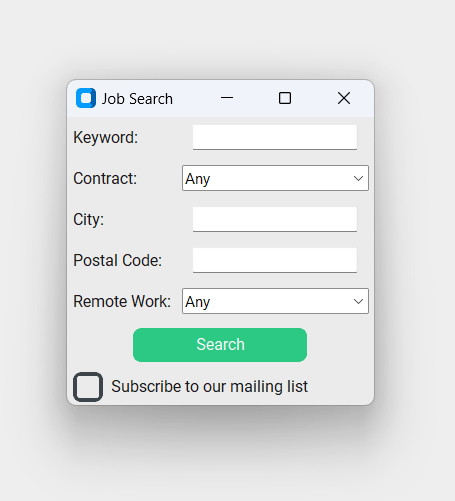

### B) Activating the search_job button
The second step consists of making the buttons alive. Specifically, we define a function to activate the search button, so that filtered results are returned based on the chosen criteria.

### C) Creating a new winfow for job_listings_displays
By default, python returns the result in hte code environment. However, we can create another function to display the filtered jobs in a new window in a table format.

## Part 3 : sending email
### A) Upgrading the interface
Finally we upgrade the interface so that the user can choose receiving the filtered jobs by mail. The word 'choice' is very important. Indeed, we define a final function, which displays new interactable buttons in the interface only if the users wishes to receive the jobs by email (and it is activated when the user clicks on the receive by mail checkbox).

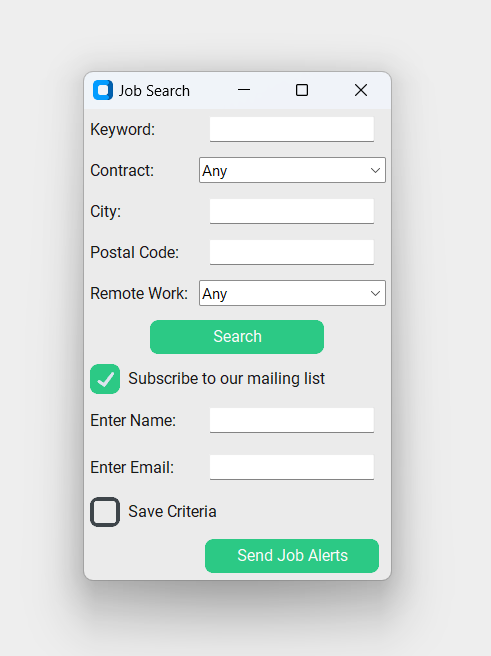

### B) Activating the save criteria checkbox and send job alerts button
Once the users clicks on the checkbox, new entries appear where he will have to enter his name, email, and save his criterias before sending the jobs by mail. The send button is activated the same the search button was : with another function.

### Email display format

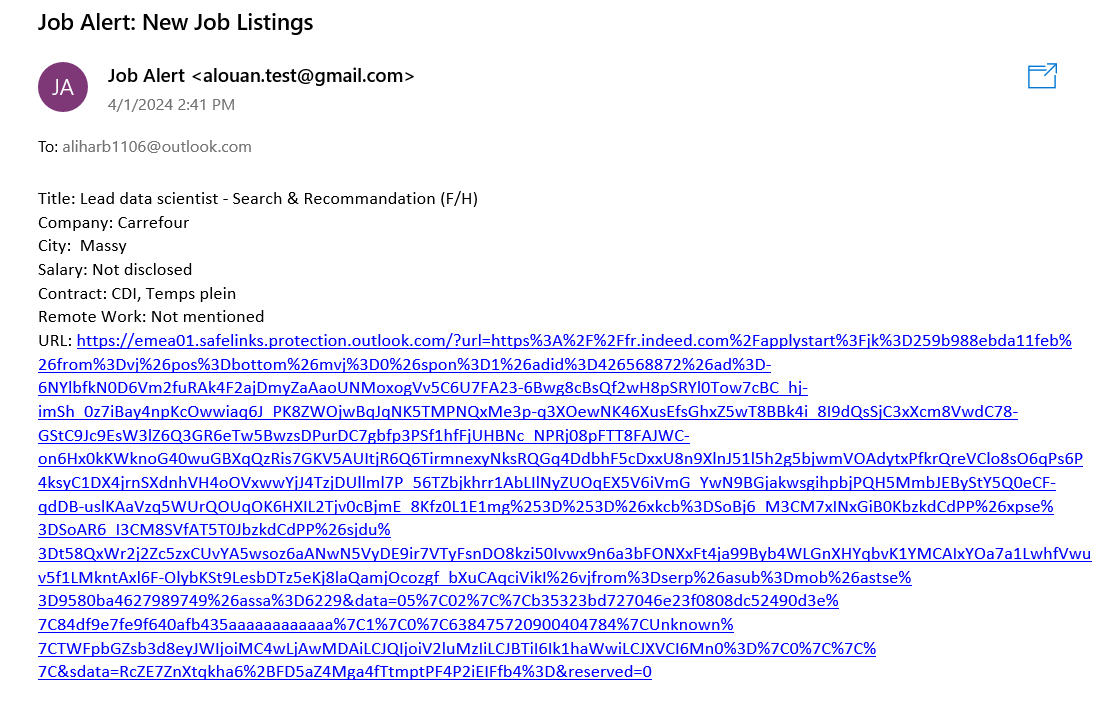
